In [15]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from sklearn.neighbors import KernelDensity
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%config InlineBackend.figure_format='retina'
load_dotenv()

output = os.getenv('OUTPUT')
hipp_unfold_dir = os.getenv('HIPP_UNFOLD_DIR')

subject = 'HCD0001305'
max_plot = 10_000


In [16]:
# N-streamline length numpy arrays with glasser ROIs and streamline-endpoint coordinates.
streamline_rois        = np.load(f'{output}/{subject}/streamlines-glasser_ROIs.npy')
streamline_hipp_coords = np.load(f'{output}/{subject}/streamlines-hipp_coordinates_space-T1.npy')

# Load midthickness from HippUnfold.
gii_L = nib.load(f'{hipp_unfold_dir}/sub-{subject}/surf/sub-{subject}_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii')
gii_R = nib.load(f'{hipp_unfold_dir}/sub-{subject}/surf/sub-{subject}_hemi-R_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii')

faces_L = gii_L.darrays[0].data
faces_R = gii_R.darrays[0].data

vertices_L = gii_L.darrays[1].data
vertices_R = gii_R.darrays[1].data


Plot streamline endpoint density on hippocampal surface.

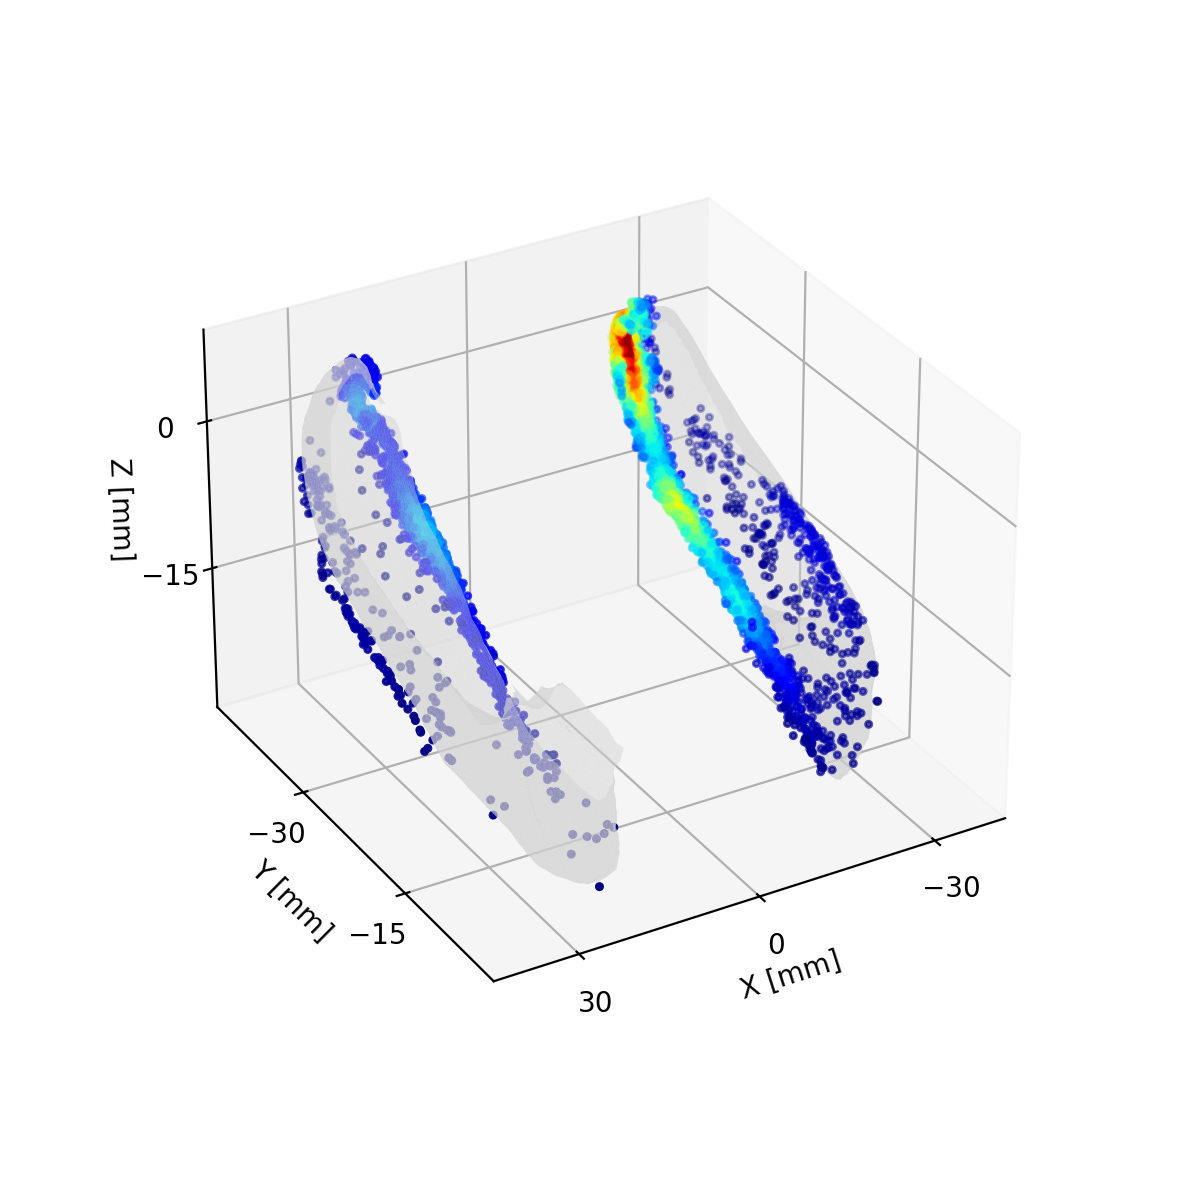

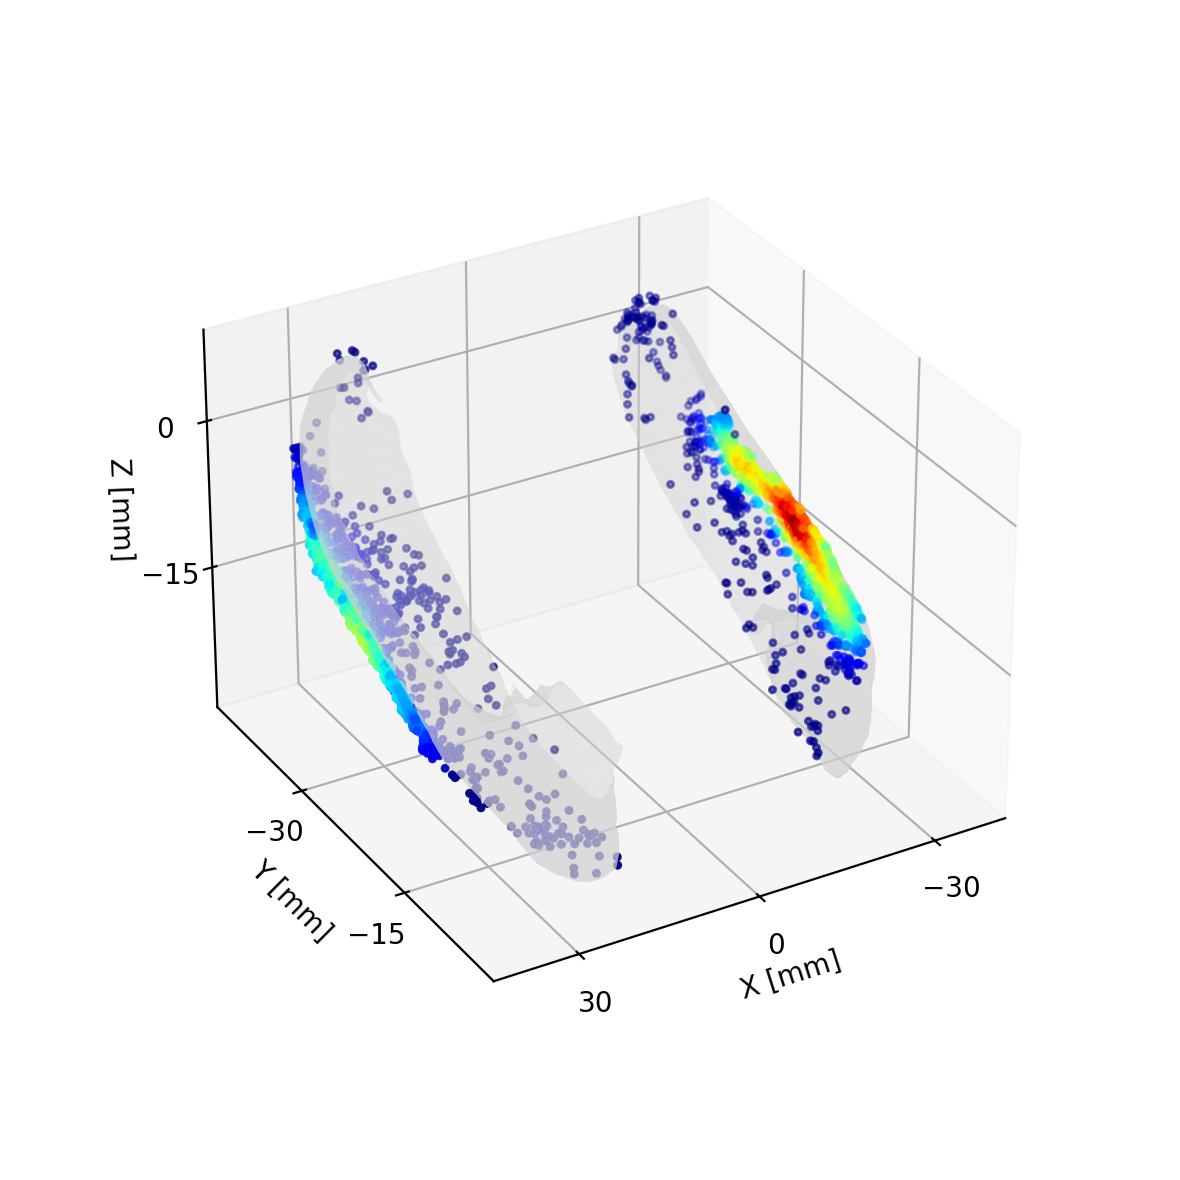

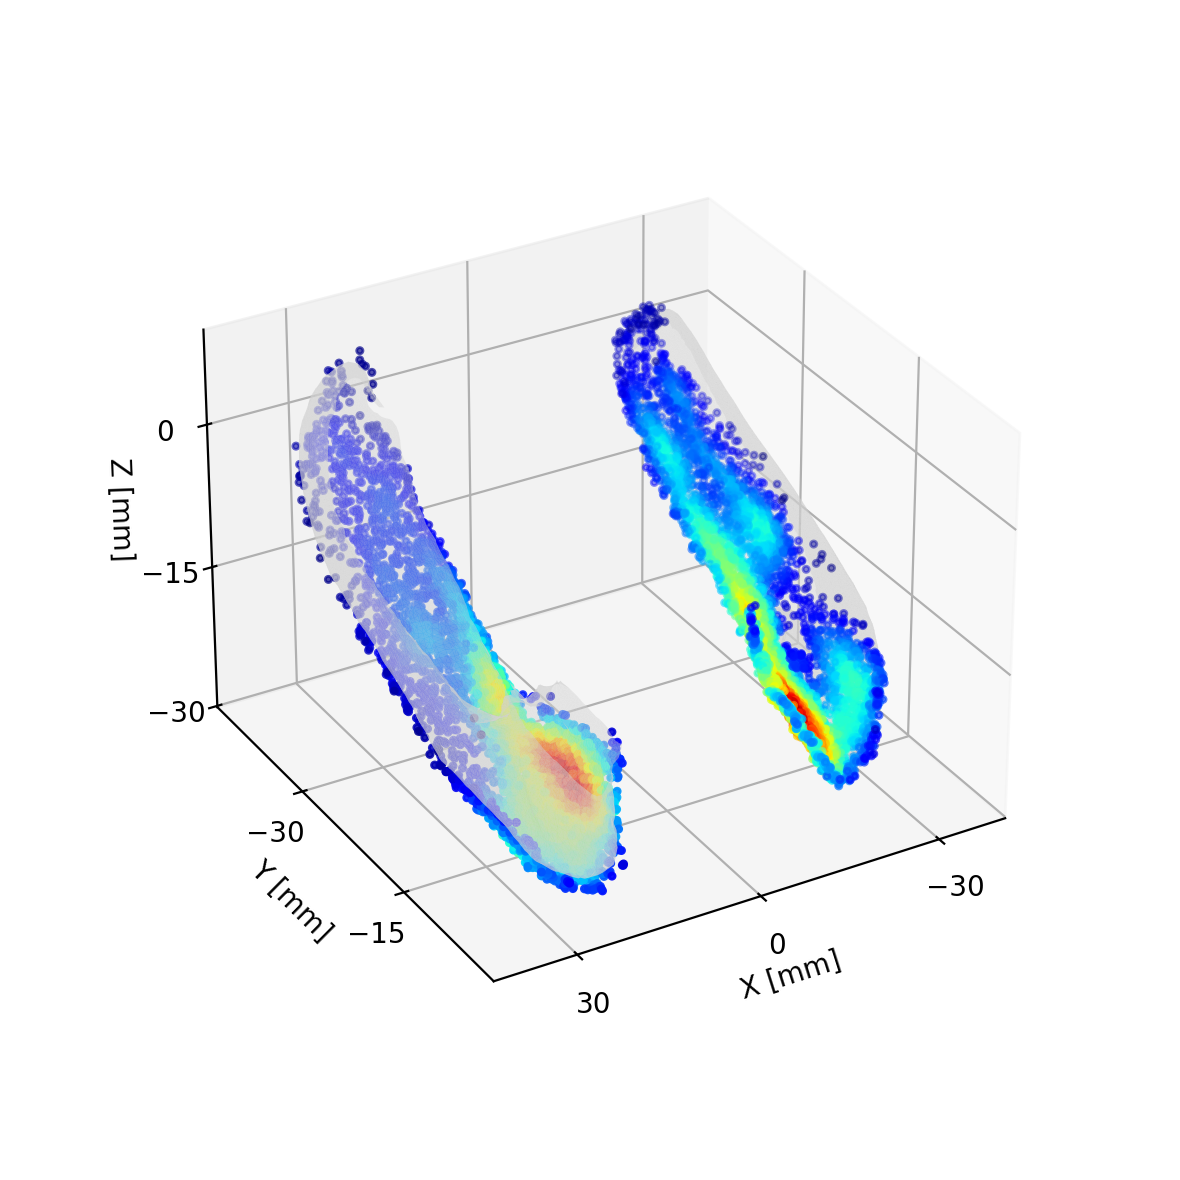

In [17]:

for rois in [
    ['V1','V2','V3','V4'],     # Early_Visual
    ['TF','TGv','TGd','TE2p'], # Lateral_Temporal
    ['EC']                     # Medial_Temporal
    ]:

    streamline_idx = np.argwhere(np.isin(streamline_rois, rois)).flatten()
    np.random.shuffle(streamline_idx)
    streamline_idx = streamline_idx[:max_plot]

    coords = streamline_hipp_coords[streamline_idx]
    x = coords[:,0]
    y = coords[:,1]
    z = coords[:,2]

    # Estimate density with KDE
    kde = KernelDensity(bandwidth=1.5).fit(coords)
    dens = np.exp(kde.score_samples(coords))

    # Different viewpoints: (elev, azim)
    views = [(30,60)]

    fig = plt.figure(figsize=(6, 6))
    for i, (elev, azim) in enumerate(views, 1):

        ax = fig.add_subplot(1, len(views), i, projection='3d')
        p = ax.scatter(x, y, z, c=dens, cmap='jet', s=5)
        ax.view_init(elev=elev, azim=azim)

        mesh_L = Poly3DCollection(vertices_L[faces_L], facecolor='lightgray', edgecolor='none', alpha=0.5)
        mesh_R = Poly3DCollection(vertices_R[faces_R], facecolor='lightgray', edgecolor='none', alpha=0.5)

        ax.add_collection3d(mesh_L)
        ax.add_collection3d(mesh_R)

        # Choose number of ticks
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.zaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.set_xlabel('X [mm]')
        ax.set_ylabel('Y [mm]')
        ax.set_zlabel('Z [mm]')

        ax.grid(alpha=.15)
        ax.set_box_aspect(None, zoom=0.8)

    plt.tight_layout()
    plt.savefig(f'plots/endpoint_density_{rois[0]}.svg')
    plt.show()

